We hide the massage in the picture using a manual SVD algorithm

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Algorithm for power method
def power_method(A, max_iter=200, tol=1e-5):
    """Power Method for the largest eigenvalue."""
    n = A.shape[0]
    v = np.random.rand(n)
    v = v / np.linalg.norm(v)
    lam_prev = 0

    for i in range(max_iter):
        v_new = A @ v
        v_new_norm = np.linalg.norm(v_new)
        if v_new_norm < 1e-9: break # Avoid division by zero
        v_new = v_new / v_new_norm
        lam = v_new.T @ (A @ v_new)
        if abs(lam - lam_prev) < tol: break
        v = v_new
        lam_prev = lam

    return lam, v

def svd_manual(X, k):
    """Manual SVD using Deflation"""
    M = np.dot(X.T, X)
    U_list, S_list, Vt_list = [], [], []
    M_curr = M.copy()

    for i in range(k):
        iterations = 200
        eigenval, v = power_method(M_curr, max_iter=iterations)

        if eigenval <= 1e-9: # Stop if values are too small
            print(f"\n[Info] Stopped at component {i} due to precision.")
            break

        sigma = np.sqrt(eigenval)
        u = np.dot(X, v) / sigma

        S_list.append(sigma)
        Vt_list.append(v)
        U_list.append(u)

        # Deflation
        M_curr = M_curr - eigenval * np.outer(v, v)

    return np.array(U_list).T, np.array(S_list), np.array(Vt_list)

# Variables (image, message, scaling)
MESSAGE = "Hidden Message"
SCALE_FACTOR = 1.0
FILENAME = "Blanco"

# Conversion function
def text_to_numbers(text):
    return [ord(c) for c in text]

# 1. Load Image
print("\n>>> PREPARING DATA...")
files = [f for f in os.listdir('.') if f.endswith(('.jpg', '.png', '.jpeg'))]

if len(files) > 0:
    img = plt.imread(files[0])
    # Handle alpha channel or different formats
    if img.ndim == 3 and img.shape[2] >= 3: img = img[:,:,:3]
    # Normalize if necessary
    if img.max() <= 1.0: img = img * 255

    img_original_display = img.astype(np.uint8)
else:
    print("ERROR: No image uploaded on the left!") # Or "in the directory"
    img = None

if img is not None:
    img_float = img.astype(float)
    R, G, B = img_float[:,:,0], img_float[:,:,1], img_float[:,:,2]

    # 2. MANUAL SVD

    matrix_h, matrix_w = B.shape # Get number of rows and columns
    k_required = min(matrix_h, matrix_w) # Find the minimum to determine number of singular values

    print(f"\n>>> ⚠️ STARTING MANUAL SVD on matrix {B.shape} for {k_required} components.")
    start_time = time.time()

    U_man, S_man, Vt_man = svd_manual(B, k=k_required)

    end_time = time.time()
    print(f"\n>>> ✅ Done! Manual SVD took: {end_time - start_time:.2f} seconds.")

    U, S, Vt = U_man, S_man, Vt_man

    ascii_vals = text_to_numbers(MESSAGE)
    len_msg = len(ascii_vals)

    # Hide Message
    S_mod = S.copy()

    # Place them at the tail of the singular value vector S
    idx_start = len(S) - len_msg
    idx_end = len(S)

    S_mod[idx_start:idx_end] = S[idx_start:idx_end] + (np.array(ascii_vals) * SCALE_FACTOR)

    # 3. Save image data to an .npz file
    np.savez(f"{FILENAME}.npz", U=U, S_mod=S_mod, Vt=Vt, S_original=S,
             msg_len=len_msg, factor=SCALE_FACTOR, R=R, G=G)

    # 4. Reconstruction
    B_rec = U @ np.diag(S_mod) @ Vt
    img_stego = np.dstack((R, G, B_rec))
    img_stego_display = np.clip(img_stego, 0, 255).astype(np.uint8)

    print(f"✅ File '{FILENAME}.npz' has been saved!")


>>> PREPARING DATA...

>>> ⚠️ STARTING MANUAL SVD on matrix (706, 515) for 515 components.

>>> ✅ Done! Manual SVD took: 21.81 seconds.
✅ File 'Blanco.npz' has been saved!


We display the original picture

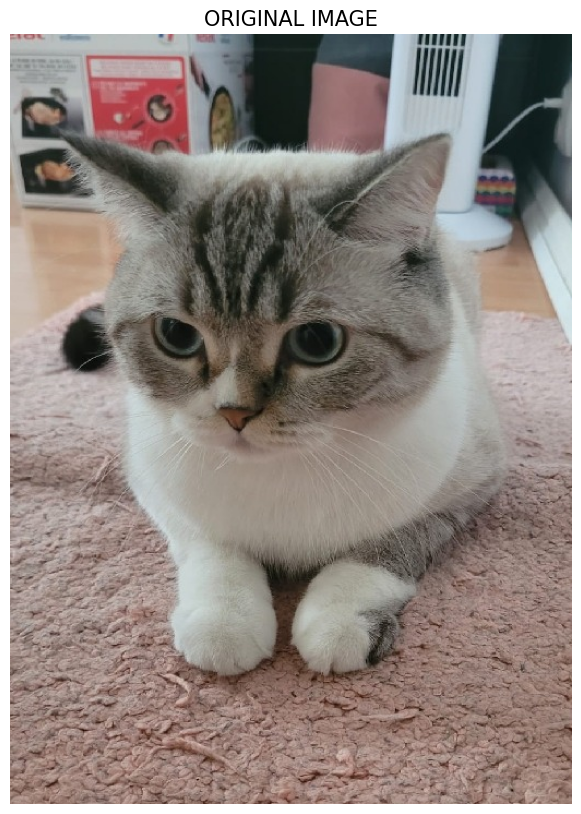

In [13]:
if 'img_original_display' in locals():
    plt.figure(figsize=(10, 10))
    plt.imshow(img_original_display)
    plt.title("ORIGINAL IMAGE", fontsize=15)
    plt.axis('off')
    plt.show()
else:
    print("⚠️ Run Cell 1 first!")

We display the reconstructed picture (after entering the message)

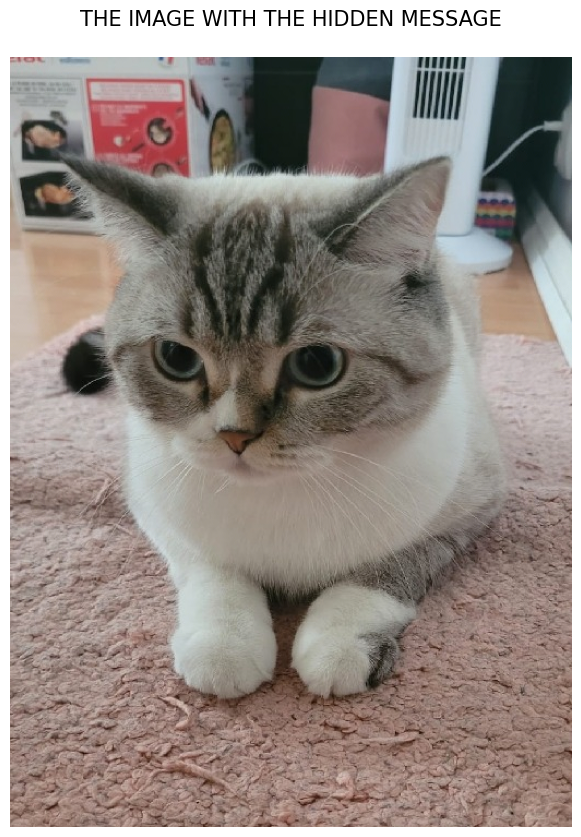

In [12]:
if 'img_stego_display' in locals():
    plt.figure(figsize=(10, 10))
    plt.imshow(img_stego_display)
    plt.title("THE IMAGE WITH THE HIDDEN MESSAGE\n", fontsize=15)
    plt.axis('off')
    plt.show()
else:
    print("⚠️  Run Cell 1 first!")

A graphic to show the spectrum of singular values in the S vector (after hiding the message)

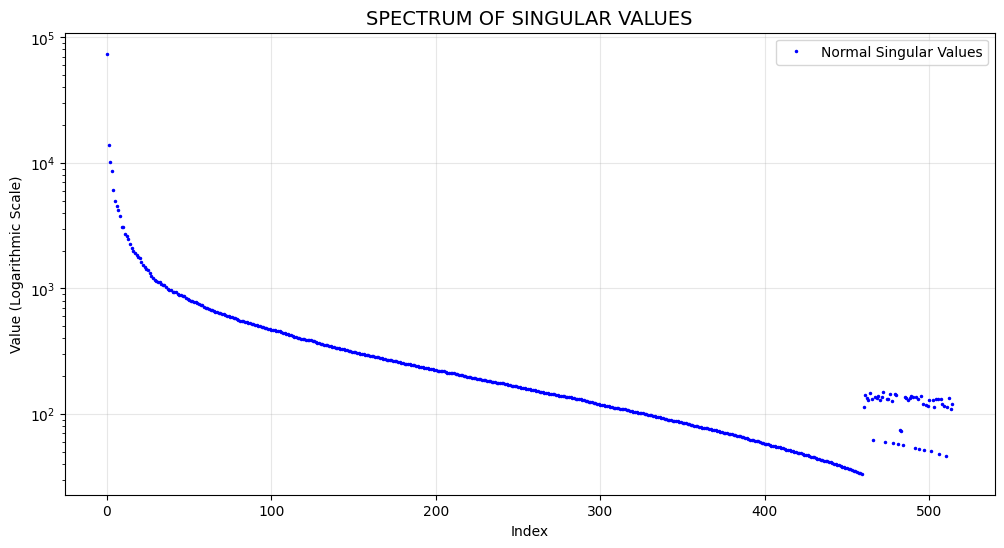

In [11]:
if 'S_mod' in locals():
    plt.figure(figsize=(12, 6))

    # Draw all points in vector S(the modified one) in blue
    plt.semilogy(S_mod, 'b.', markersize=3, label='Normal Singular Values')

    plt.title("SPECTRUM OF SINGULAR VALUES", fontsize=14)
    plt.xlabel("Index")
    plt.ylabel("Value (Logarithmic Scale)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()
else:
    print("⚠️ Run cell 1 first!")

We extract the message from the image

In [16]:
# Conversion function
def numbers_to_text(numbers):
    chars = []
    for n in numbers:
        val = int(round(n))
        if 32 <= val <= 126: chars.append(chr(val))
        else: chars.append('?')
    return "".join(chars)

print(">>> DECRYPTING FROM .NPZ FILE...")

# Read from the saved file
try:
    # We use FILENAME defined in the previous block
    data = np.load(f"{FILENAME}.npz")
    S_mod_file = data['S_mod']
    S_orig_file = data['S_original']
    len_msg_file = int(data['msg_len'])
    scale_file = float(data['factor'])

    # To retrieve the message, calculate the difference between the modified S vector and the original one
    difference = S_mod_file - S_orig_file

    # Extract the last values corresponding to the message length
    message_values = difference[-len_msg_file:]

    # Reverse the scaling
    codes = message_values / scale_file

    recovered_message = numbers_to_text(codes)

    print("\n" + "="*70)
    print(f" MESSAGE: {recovered_message}")
    print("="*70 + "\n")

except:
    print("⚠️ Cannot find the .npz file! Run Cell 1 (the previous code block).")

>>> DECRYPTING FROM .NPZ FILE...

 MESSAGE: Hidden Message




We hide the same message in the same picture, but this time using the SVD algorithm from the numpy library to compare the running time

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Variables
MESSAGE = "Hidden Message"
SCALE_FACTOR = 1.0
FILENAME = "Blanco"

def text_to_numbers(text):
    return [ord(c) for c in text]

# 1. Load Image
print(">>> PREPARING DATA...")
files = [f for f in os.listdir('.') if f.endswith(('.jpg', '.png', '.jpeg'))]
if len(files) > 0:
    img = plt.imread(files[0])
    # Handle alpha channel or different formats
    if img.ndim == 3 and img.shape[2] >= 3: img = img[:,:,:3]
    # Normalize if necessary
    if img.max() <= 1.0: img = img * 255
    # Keep original in memory for display
    img_original_display = img.astype(np.uint8)
else:
    print("ERROR: No image uploaded on the left!")
    img = None

if img is not None:
    img_float = img.astype(float)
    R, G, B = img_float[:,:,0], img_float[:,:,1], img_float[:,:,2]

    # 2. SVD and Hide Message
    print(f">>> Starting SVD calculation on matrix {B.shape}...")

    start_time = time.time()

    # Using standard Numpy SVD
    U, S, Vt = np.linalg.svd(B, full_matrices=False)

    end_time = time.time()
    duration = end_time - start_time
    print(f" SVD Execution Time (Numpy): {duration:.4f} seconds")

    ascii_vals = text_to_numbers(MESSAGE)
    len_msg = len(ascii_vals)

    S_mod = S.copy()
    # Embed message into the smallest singular values (at the end)
    S_mod[-len_msg:] = S[-len_msg:] + (np.array(ascii_vals) * SCALE_FACTOR)

    # 3. Save image data to an .npz file
    np.savez(f"{FILENAME}.npz", U=U, S_mod=S_mod, Vt=Vt, S_original=S,
             msg_len=len_msg, factor=SCALE_FACTOR, R=R, G=G)

    # 4. Reconstruction
    B_rec = U @ np.diag(S_mod) @ Vt
    img_stego = np.dstack((R, G, B_rec))
    # Keep modified image in memory for display
    img_stego_display = np.clip(img_stego, 0, 255).astype(np.uint8)

    print(f"✅ File '{FILENAME}.npz' has been saved!")

>>> PREPARING DATA...
>>> Starting SVD calculation on matrix (706, 515)...
 SVD Execution Time (Numpy): 1.7711 seconds
✅ File 'Blanco.npz' has been saved!


We calculate the Similarity score using SSIM (Structural Similarity Index Measure)

In [9]:
from skimage.metrics import structural_similarity as ssim

# We calculate the score
(score, diff) = ssim(img_original_display, img_stego_display, channel_axis=2, data_range=255, full=True)

print(f"Similarity Score: {score}")
print(f"What percent is similar: {score * 100:.5f}%")

Similarity Score: 0.9972911057023105
What percent is similar: 99.72911%
